<a href="https://colab.research.google.com/github/Berry-of-Tech/Spot-the-Mask/blob/main/Spot_the_Mask_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import necessary libraries

In [ ]:
# for maths operations
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt

# for the directories and files operations & for system operations
import os
import sys
import glob
import pathlib
import zipfile

# for operations on images
import cv2
from PIL import  Image


# Machine learning libs
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss


# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

#Keras
from keras.utils import to_categorical

# others ibraries
from tqdm.notebook import tqdm # for progressBar

import IPython.display as ipd
from matplotlib import pyplot as plt # for visualization

In [ ]:

train = pd.read_csv('/content/drive/MyDrive/Spot the Mask Challenge/train_labels.csv')
ss = pd.read_csv('/content/drive/MyDrive/Spot the Mask Challenge/SampleSubmission (1).csv')

train_images_list = train['image'].tolist()

images_path = '/content/drive/MyDrive/Spot the Mask Challenge/images'
images_list = os.listdir(images_path)

test_images_list = [fn for fn in images_list if fn not in train_images_list]

test = pd.DataFrame(test_images_list, columns=['image'])
test['target'] = 0

# Add file names
train['file_name'] = images_path + '/' + train['image']
test['file_name'] = images_path + '/' + test['image']

In [ ]:
PATHS = {
    'cwd': './', #Current directory
    'arch': 'MODELS/', #Folder in which we're going to save our models
}

os.makedirs(PATHS['arch'], exist_ok=True)

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [ ]:
train.head(3)

,image,target,file_name
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0,/content/drive/MyDrive/Spot the Mask Challenge...
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1,/content/drive/MyDrive/Spot the Mask Challenge...
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0,/content/drive/MyDrive/Spot the Mask Challenge...


In [ ]:
test.head(3)

,image,target,file_name
0,gppgpyeceknjakxhnvcgivtzqkexdt.jpg,0,/content/drive/MyDrive/Spot the Mask Challenge...
1,qwylrrncmfibtlszybqsofemgweggl.jpg,0,/content/drive/MyDrive/Spot the Mask Challenge...
2,zjcrlegcioljqhlaowlaklxwojfpil.jpg,0,/content/drive/MyDrive/Spot the Mask Challenge...


In [ ]:
train['target'].value_counts()

0    664
1    644
Name: target, dtype: int64

In [ ]:
import random
import torch
seed = 42 # for reproductibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

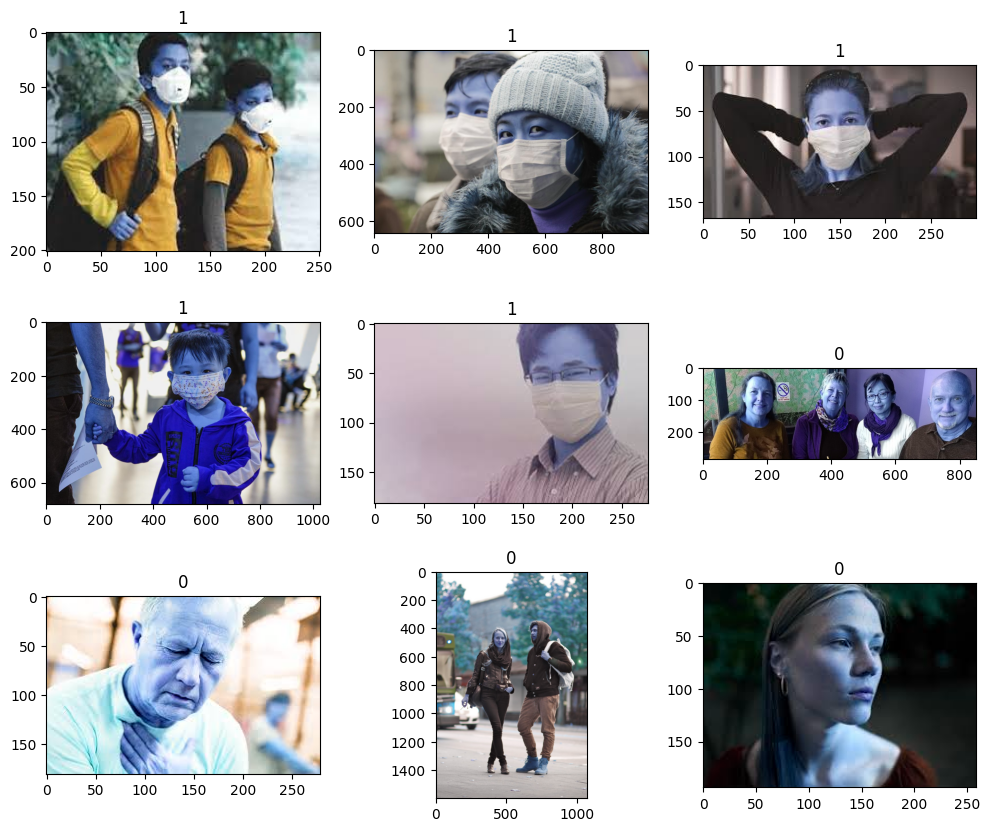

In [ ]:
#Training images
nrows = 3
rands = np.random.randint(len(train_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    np.random.seed(seed)
    img = cv2.imread(train.loc[rands[i], 'file_name'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'target'])
plt.show()

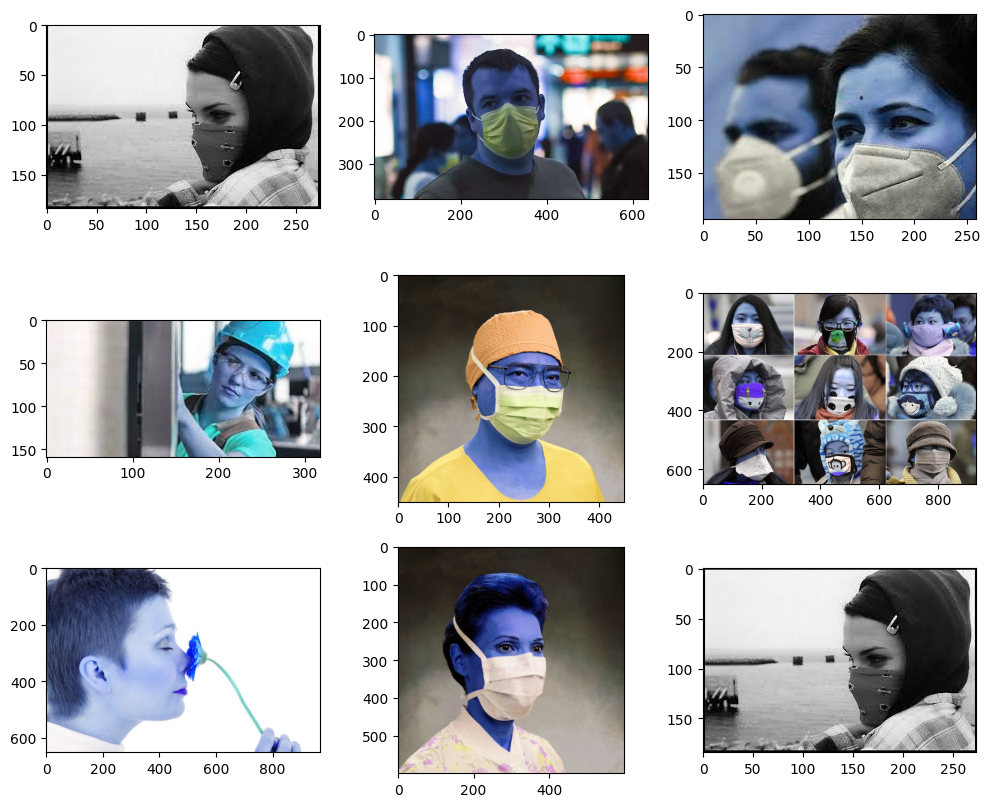

In [ ]:
#Test images
nrows = 3
rands = np.random.randint(len(test_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    np.random.seed(seed)
    img = cv2.imread(test.loc[rands[i], 'file_name'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
plt.show()

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 224x224
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [ ]:
file_name_list = train['file_name'].tolist()

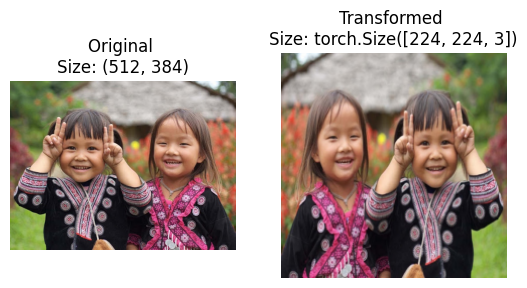

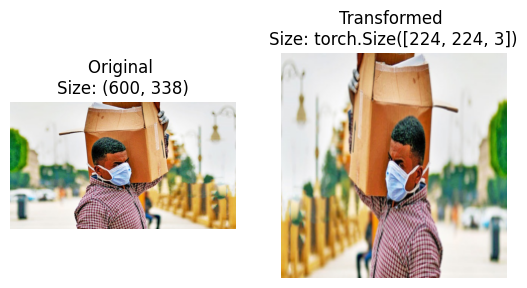

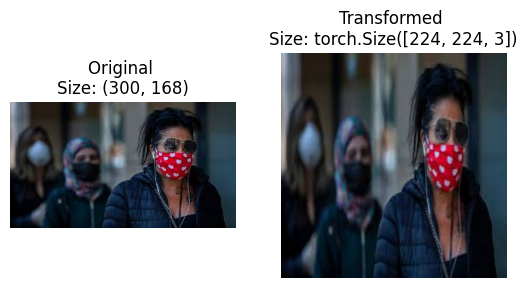

In [ ]:
from PIL import Image

def plot_transformed_images(image_paths, transform, n=3, seed=42):

    random.seed(seed)
    random_image_paths = random.sample(file_name_list, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")


plot_transformed_images(file_name_list,
                        transform=data_transform,
                        n=3)

Generally, the larger the shape of the image, the more information a model can recover.

For example, an image of size [256, 256, 3] will have 16x more pixels than an image of size [64, 64, 3] ((2562563)/(64643)=16).

However, the tradeoff is that more pixels requires more computations.

#My custom dataset

In [ ]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class MaskDataset(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, df, size=(224, 224), task='train', use_tfms=True, **kwargs):

        super(MaskDataset, self).__init__()
        self.df = df
        self.task = task
        self.size = size
        self.use_tfms = use_tfms
        self.c = 2

        self.train_transforms = transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomHorizontalFlip(p=0.5),
        ])
        self.transforms = transforms.Compose([
          transforms.ToTensor(),
        ])

    # 3. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
      "Returns the total number of samples."
      return len(self.df)

    # 4. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, idx):
      fn = self.df.loc[idx, 'file_name']

      img = cv2.imread(fn)
      img = cv2.resize(img, self.size)

      if self.use_tfms: spec = self.train_transforms(img)
      img = self.transforms(img)

      output = {
             'image': img,
          }

      if self.task == 'train':
            label = self.df.loc[idx, 'target']
            output.update({
              'label': torch.tensor( to_categorical(label, self.c), dtype=torch.float )
          })

      return output



In [ ]:
class MaskModel(nn.Module):
    def __init__(self, arch_name, pretrained=True, layer='fc', fc_size=512, out_size=2):
        super(MaskModel, self).__init__()

        #Attributes and Initialization
        self.arch = getattr(models, arch_name)(pretrained)
        setattr(self.arch, layer, torch.nn.Linear(fc_size, out_size))

        #Weight Initialization
        torch.nn.init.xavier_normal_(getattr(getattr(self.arch, layer), 'weight'))

    def forward(self, x):
        x = self.arch(x)
        x = F.sigmoid(x)

        return x

#Functions Definition

In [ ]:
 ################## training Function ####################

def training_fn(dataloader, model, optimizer, loss_fn, epoch):
    # Setup train loss and train accuracy values
    avg_loss, avg_acc = 0, 0

    # pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}')
    model.to(device)

    # Put model in train mode
    model.train()

    # Loop through data loader data batches, i = batch
    for i, data in enumerate(dataloader):

      # Send data to target device
      X, y = data['image'].to(device), data['label'].to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      avg_loss += loss #loss.item

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      #5. step the optimizer
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      avg_acc += (y.argmax(1) == y_pred.argmax(1)).float().mean()

      #OR
      #y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      #train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    avg_loss_nump = avg_loss.cpu().detach().numpy()
    avg_acc_nump = avg_acc.cpu().detach().numpy()

    # Adjust metrics to get train loss and accuracy per batch
    avg_loss = avg_loss_nump / len(dataloader)
    avg_acc = avg_acc_nump / len(dataloader)

    print('[Training] Epoch {} : Loss: {:.5f} - Acc : {:.5f}'.format(epoch, avg_loss, avg_acc))


#######Evaluation Function #########

def evaluate(dataloader, model, loss_fn):
    avg_loss, avg_acc = 0, 0
    avg_logloss = 0

    # Put model in eval mode
    model.eval()

    # Turn on inference context manager
    with torch.inference_mode():
      # Loop through DataLoader batches
      for data in dataloader:
        X = data['image'].to(device)
        y = data['label'].to(device)

        # 1. Forward pass
        test_pred_logits = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y)
        avg_loss += loss

        # Calculate and accumulate accuracy
        avg_acc += ( y.argmax(1) == test_pred_logits.argmax(1) ).float().mean()

        #test_pred_labels = test_pred_logits.argmax(dim=1)
        #test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

      avg_loss_nump = avg_loss.cpu().detach().numpy()
      avg_acc_nump = avg_acc.cpu().detach().numpy()

      avg_loss =  avg_loss_nump / len(dataloader)
      avg_acc = avg_acc_nump / len(dataloader)

    print("[Evaluation] Loss: {:.5f} - Acc : {:.5f}".format(avg_loss,
                                                    avg_acc))

    return avg_loss




 ################## prediction Function ####################


def predict(df, size, MODELS, bs=8):
    test_ds = MaskDataset(df, task='test', size=size, use_tfms=False)
    testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

    #print(testloader)
    predictions_labels = []
    predictions_proba = []

    out = None

    for data in tqdm(testloader):
        x = data['image'].to(device)

        for i in range(n_folds):
            if i == 0: out = MODELS[i](x)
            else: out += MODELS[i](x)

        out /= n_folds
        out_labels = out.argmax(1).cpu().detach().numpy()
        out_probas = out.cpu().detach().numpy()

        predictions_labels += out_labels.tolist()
        predictions_proba += out_probas.tolist()

    return predictions_labels ,predictions_proba


################## Run training over folds Function ####################

def run_fold(fold, bs=16,
             eval_bs=8,
             lr=1e-4,
             size=(224, 224),
             arch='resnet34',
             layer='fc',
             fc_size=512,
             path=PATHS['arch']):

    best_logloss = np.inf

    fold_train = train[train.fold != fold].reset_index(drop=True)
    fold_val = train[train.fold == fold].reset_index(drop=True)

    train_ds = MaskDataset(fold_train, size=size)
    val_ds = MaskDataset(fold_val, size=size, use_tfms=False)

    trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
    validloader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

    model = MaskModel(arch, layer=layer, fc_size=fc_size)
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


    loader = tqdm(range(epochs), desc='Training')

    for epoch in loader:
        training_fn(trainloader, model, optimizer, loss_fn, epoch)
        test_logloss = evaluate(validloader, model, loss_fn)

        if test_logloss < best_logloss:
            best_logloss = test_logloss
            torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')

    return best_logloss

 ################## training Function ####################

def load_models(arch='resnet34',
                layer='fc',
                fc_size=512,
                path=PATHS['arch']):

    MODELS = []

    for i in range(n_folds):
        MODELS.append(MaskModel(arch_name=arch, layer=layer, fc_size=fc_size))
        MODELS[i].to(device)
        MODELS[i].load_state_dict(torch.load(f'{path}model_state_dict_{i}.bin'))
        MODELS[i].eval()

    return MODELS

#Training
For the training part, we are going to implement the well known corss-validation technique of K-Fold. So we tried our experiments with 10 folds.

In [ ]:
n_folds = 5 # number of folds used

train['fold'] = 0

#creating our folds using a special class of Scikit-learn
fold = StratifiedKFold(n_splits = n_folds, random_state= None)

for i, (tr, vr) in enumerate(fold.split(train, train['target'])):
    train.loc[vr, 'fold'] = i

In [ ]:
epochs = 5                # training epochs
size = (224, 224)          # image size
arch = 'densenet161'       # pre-trained model architecture used
layer = 'classifier'
fc_size = 2208             # Fully connected layer size
bs = 32                    # training Batch size
eval_bs = 4                # Evaluation Batch size
lr = 1e-4                  # learning rate


avg_logloss = 0        # variable for getting the average of loss results after training
best_fold = 0          # variable for getting the best fold number after training
fold_logloss = np.inf  # initialize fold loss to infinity


######################################  TRAINING PART ###################################
# run training loop over our 10 folds

for fold in range(n_folds):
  _score = run_fold(fold,
                      bs=bs,
                      eval_bs=eval_bs,
                      arch=arch,
                      layer=layer,
                      fc_size=fc_size,
                      size=size,
                      lr=lr)

  avg_logloss += _score

  if fold_logloss > _score:
      fold_logloss = _score
      best_fold = fold

######################################  TRAINING PART ###################################


print("\n [INFO] Avg LogLoss: ", avg_logloss/n_folds)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training:   0%|          | 0/5 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.23170 - Acc : 0.90814
[Evaluation] Loss: 0.12955 - Acc : 0.96591
[Training] Epoch 1 : Loss: 0.03272 - Acc : 0.99294
[Evaluation] Loss: 0.08619 - Acc : 0.98485
[Training] Epoch 2 : Loss: 0.01990 - Acc : 0.99432
[Evaluation] Loss: 0.11221 - Acc : 0.97727
[Training] Epoch 3 : Loss: 0.00592 - Acc : 1.00000
[Evaluation] Loss: 0.09607 - Acc : 0.98485
[Training] Epoch 4 : Loss: 0.00258 - Acc : 1.00000
[Evaluation] Loss: 0.09433 - Acc : 0.98485


Training:   0%|          | 0/5 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.25772 - Acc : 0.88120
[Evaluation] Loss: 0.11041 - Acc : 0.96212
[Training] Epoch 1 : Loss: 0.02939 - Acc : 0.99432
[Evaluation] Loss: 0.13891 - Acc : 0.94697
[Training] Epoch 2 : Loss: 0.01083 - Acc : 0.99905
[Evaluation] Loss: 0.04612 - Acc : 0.98485
[Training] Epoch 3 : Loss: 0.00354 - Acc : 1.00000
[Evaluation] Loss: 0.04798 - Acc : 0.98485
[Training] Epoch 4 : Loss: 0.00194 - Acc : 1.00000
[Evaluation] Loss: 0.05433 - Acc : 0.98106


Training:   0%|          | 0/5 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.26292 - Acc : 0.90152
[Evaluation] Loss: 0.06150 - Acc : 0.96212
[Training] Epoch 1 : Loss: 0.01979 - Acc : 0.99811
[Evaluation] Loss: 0.03811 - Acc : 0.98485
[Training] Epoch 2 : Loss: 0.00617 - Acc : 1.00000
[Evaluation] Loss: 0.02965 - Acc : 0.98485
[Training] Epoch 3 : Loss: 0.00336 - Acc : 1.00000
[Evaluation] Loss: 0.04197 - Acc : 0.98106
[Training] Epoch 4 : Loss: 0.00208 - Acc : 1.00000
[Evaluation] Loss: 0.03991 - Acc : 0.97727


Training:   0%|          | 0/5 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.23813 - Acc : 0.90720
[Evaluation] Loss: 0.06805 - Acc : 0.96212
[Training] Epoch 1 : Loss: 0.03376 - Acc : 0.99395
[Evaluation] Loss: 0.08986 - Acc : 0.96212
[Training] Epoch 2 : Loss: 0.01831 - Acc : 0.99621
[Evaluation] Loss: 0.06378 - Acc : 0.98106
[Training] Epoch 3 : Loss: 0.00539 - Acc : 0.99905
[Evaluation] Loss: 0.08673 - Acc : 0.96970
[Training] Epoch 4 : Loss: 0.00595 - Acc : 0.99811
[Evaluation] Loss: 0.10068 - Acc : 0.96212


Training:   0%|          | 0/5 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.26726 - Acc : 0.88410
[Evaluation] Loss: 0.07422 - Acc : 0.98106
[Training] Epoch 1 : Loss: 0.02947 - Acc : 0.99337
[Evaluation] Loss: 0.06457 - Acc : 0.97727
[Training] Epoch 2 : Loss: 0.01536 - Acc : 0.99621
[Evaluation] Loss: 0.14214 - Acc : 0.94318
[Training] Epoch 3 : Loss: 0.00578 - Acc : 0.99905
[Evaluation] Loss: 0.05025 - Acc : 0.97348
[Training] Epoch 4 : Loss: 0.00271 - Acc : 1.00000
[Evaluation] Loss: 0.05460 - Acc : 0.97348

 [INFO] Avg LogLoss:  0.05519810156388717


In [ ]:
# 1
MODELS = load_models(arch=arch, layer=layer, fc_size=fc_size)
# 2
predictions_labels, predictions_proba = predict(test, size=size, MODELS=MODELS, bs=2)

  0%|          | 0/255 [00:00<?, ?it/s]

In [ ]:
submission = pd.DataFrame()
submission['id'] = test['image']
for i, label in enumerate(["0", "1"]):
    submission[label] = 0
for i, label in enumerate(["0", "1"]):
    submission.loc[:,label] = np.array(predictions_proba)[:,i]
submission['target'] = predictions_labels

#show predicted values
submission.head()

,id,0,1,target
0,gppgpyeceknjakxhnvcgivtzqkexdt.jpg,0.007539,0.993715,1
1,qwylrrncmfibtlszybqsofemgweggl.jpg,0.003753,0.996824,1
2,zjcrlegcioljqhlaowlaklxwojfpil.jpg,0.001259,0.999026,1
3,mtkmqoxjnmplockjwdilejfsrxcbvy.jpg,0.998953,0.000891,0
4,rwrhwxbhdpdvlaxkattftklqiorcpo.jpg,0.001199,0.998783,1


In [ ]:
# Format dataframe to match Zindi sample submission file
# and use experiment variables to keep relevant infos on it
subs = submission[['id', '1']]
subs.columns = ['id', 'target']
subs.to_csv(f'spot_{arch}_folds_{n_folds}_epochs_{epochs}_size_{size}_LR_{lr}.csv', index=False)

In [ ]:
y_true = submission['target'].to_list()
y_true = np.array(y_true)

y_pred = submission['1'].to_list()
y_pred = np.array(y_pred)

ll = log_loss(y_true=y_true, y_pred=y_pred)
print("[INFO] Your LogLoss score is {}".format(ll))

[INFO] Your LogLoss score is 0.023863371267641684
